```
This notebook sets up and runs a test case for analyzing Kelvin waves
Copyright (C) 2018 - 2022 SINTEF Digital
Copyright (C) 2018 - 2022 Norwegian Meteorological Institute

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if p.endswith("gpuocean/src")][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

GPUOcean code from: 846e91047b303fc839af80b9868a628ee4fb2c7a on branch reduced_gravity


# Oslofjord
Testing of Nils projected files

In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

In [3]:
from gpuocean.utils import IPythonMagic, Common, NetCDFInitialization, WindStress, OceanographicUtilities

from gpuocean.SWEsimulators import CDKLM16

In [4]:
%cuda_context_handler barotropic_gpu_ctx

In [5]:
%cuda_context_handler baroclinic_gpu_ctx

Path to the test file

In [6]:
source_url = "/sintef/data/OsloFjord/test_polstere_1h_0007.nc"

## Inspecting file structure and content

In [7]:
from netCDF4 import Dataset
nc = Dataset(source_url)

In [8]:
import xarray as xr
ds = xr.open_dataset(source_url)
ds

<xarray.Dataset>
Dimensions:     (ocean_time: 720, s_rho: 42, s_w: 43, eta_rho: 741, xi_rho: 397, xi_u: 396, eta_v: 740)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2014-06-30T13:00:00 ... 2014-07-3...
  * s_rho       (s_rho) float64 -0.9881 -0.9643 -0.9405 ... -0.03571 -0.0119
  * s_w         (s_w) float64 -1.0 -0.9762 -0.9524 ... -0.04762 -0.02381 0.0
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/15)
    projection  int32 ...
    Cs_r        (s_rho) float64 ...
    Cs_w        (s_w) float64 ...
    h           (eta_rho, xi_rho) float32 ...
    mask_rho    (eta_rho, xi_rho) float32 ...
    angle       (eta_rho, xi_rho) float32 ...
    ...          ...
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    temp        (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    u           (ocean_time, s_rho, eta_rho, xi_u) float32 ...
    v           (ocean_time, s_rho, eta_v, xi_rho) float32 ...
    lat_rho     (eta_rho, xi_rho) float32 ...
    lon_rho     (eta_rho, xi_rho) float32 ...

Animation utils

In [9]:
import animation_utils

## Generating GPUOcean Simulation from Input

General parameters

In [10]:
dimY, dimX = ds.h.data.shape

In [11]:
x0, x1, y0, y1 = 5, dimX-5, 175, dimY-5

In [12]:
t_start = 5*24
t_stop =  5*24 + 6

In [13]:
T = (t_stop-t_start)*3600  #Input

In [14]:
timestep_indices = [list(np.arange(t_start, t_stop+1))]

#### Initial conditions

In [15]:
barotropic_data_args, baroclinic_data_args = NetCDFInitialization.getCombinedInitialConditions(source_url, x0, x1, y0, y1, 1024.0, timestep_indices=timestep_indices, norkyst_data=False, land_value=0.0, download_data=False)

Add some wind

In [16]:
from gpuocean.utils import WindStress

def generate_wind_field(wind_angle_deg, T, shift=None):
    """Generating WindStress object with spatially constant, hourly varying wind 
    according to the standard shape in Oslofjord (see Oslofjord-ArtificialParameters.ipynb)
    
    wind_angle_deg - angle of wind field towards north in degree!
    """

    wind_angle = np.deg2rad(wind_angle_deg)

    # Reference wind speed for 0 - 24h 
    wind_u_ref = np.zeros(24)
    wind_u_ref[:10] = -0.5*(np.sin(2*np.pi*(np.arange(0,10)-2.5)/10)+1)
    wind_u_ref[10:] = 5*(np.sin(2*np.pi*(np.arange(10,24)+0.5)/14)+1)

    # Wind fields for 0 - 24h
    wind_u = list(np.cos(wind_angle)*wind_u_ref[:,np.newaxis][:,np.newaxis].astype(np.float32))
    wind_v = list(np.sin(wind_angle)*wind_u_ref[:,np.newaxis][:,np.newaxis].astype(np.float32))

    # Shifting that reference hours align with t_0
    if shift is None:
        shift = datetime.datetime.utcfromtimestamp(nc["ocean_time"][t_start]).hour
    for shift_hour in range(shift):
        wind_u.append(wind_u.pop(0))
        wind_v.append(wind_v.pop(0))

    # Cut relevant time span
    wind_u = wind_u[0:int(T/3600+1)]
    wind_v = wind_v[0:int(T/3600 +1)]

    # Construct time array in simulator time (starting with 0)
    ts = np.arange(T+1, step=3600)

    # Init WindStress object
    wind = WindStress.WindStress(t=ts, wind_u=wind_v, wind_v=wind_u)
    wind.compute_wind_stress_from_wind()

    return wind 

#### Test Simulations

In [17]:
barotropic_data_args["wind"] = generate_wind_field(45.0, T)

In [18]:
barotropic_sim = CDKLM16.CDKLM16(barotropic_gpu_ctx, **NetCDFInitialization.removeMetadata(barotropic_data_args), dt=0.0, write_netcdf=True)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [19]:
subt = 3600
for runt in range(int(T/subt)):
    barotropic_sim.step(subt)


In [20]:
with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
    anim = animation_utils.ncAnimation(barotropic_sim.sim_writer.output_file_name, "gpuocean", comment="GPUOcean")
    anim.save("anims/barotropic_test.mp4")

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/matplotlib/colors.py:576: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


In [21]:
baroclinic_data_args["wind"] = generate_wind_field(45.0, T)
baroclinic_data_args["wind_stress_factor"] = 0.3

In [22]:
baroclinic_sim = CDKLM16.CDKLM16(baroclinic_gpu_ctx, **NetCDFInitialization.removeMetadata(baroclinic_data_args), dt=0.0, write_netcdf=True)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [23]:
subt = 3600
for runt in range(int(T/subt)):
    baroclinic_sim.step(subt)

In [24]:
with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
    anim = animation_utils.ncAnimation(baroclinic_sim.sim_writer.output_file_name, "gpuocean-reduced_grav", comment="GPUOcean")
    anim.save("anims/baroclinic_test.mp4")

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/numpy/ma/core.py:1158: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/numpy/ma/core.py:1015: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/numpy/ma/core.py:1158: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/numpy/ma/core.py:1015: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


Just for reference, a combined simuilator

In [25]:
from gpuocean.SWEsimulators import CombinedCDKLM16

sims = CombinedCDKLM16.CombinedCDKLM16(barotropic_sim=barotropic_sim, baroclinic_sim=baroclinic_sim)

In [26]:
from gpuocean.utils import Observation
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [27]:
observation_type = dautils.ObservationType.UnderlyingFlow 
    
observation_args = {'observation_type': observation_type,
                'nx': sims.nx, 'ny': sims.ny,
                'domain_size_x': sims.nx*sims.dx,
                'domain_size_y': sims.ny*sims.dy,
                'land_mask': sims.getLandMask()
                }

trajectories = Observation.Observation(**observation_args)

In [28]:
initx = [ 6000]
inity = [12000]

num_drifters = len(initx)

drifters = GPUDrifterCollection.GPUDrifterCollection(sims.barotropic_gpu_ctx, num_drifters,
                                                    boundaryConditions = sims.boundary_conditions,
                                                    domain_size_x = trajectories.domain_size_x,
                                                    domain_size_y = trajectories.domain_size_y,
                                                    gpu_stream = sims.gpu_stream,
                                                    wind=barotropic_data_args["wind"], # using the barotropic wind
                                                    wind_drift_factor=0.02/2 # halfend since drift kernel called twice
                                                    )

drifter_pos_init = np.array([initx, inity]).T
drifters.setDrifterPositions(drifter_pos_init)

In [29]:
sims.attachDrifters(drifters)
trajectories.add_observation_from_sim(sims)

In [30]:
sims.combinedStep(T, trajectory_dt=60, trajectories=trajectories)

(43200.0, 43200.0)

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  # Remove the CWD from sys.path while we load stuff.


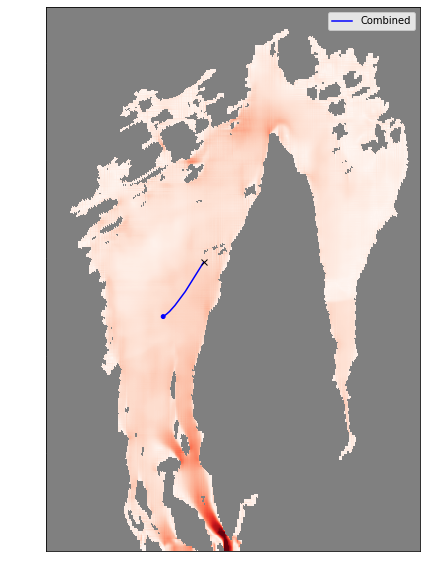

In [31]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

combined_eta, combined_u, combined_v = sims.download() 
uv_field = np.sqrt(combined_u**2 + combined_v**2)


domain_extent = [0, sims.nx*sims.dx, 0, sims.ny*sims.dy]

velo_cmap = copy.deepcopy(plt.cm.Reds)
velo_cmap.set_bad("grey", alpha = 1.0)

ax.imshow(uv_field, interpolation="none", origin='lower', 
                cmap=velo_cmap, 
                vmin=0.0, vmax=0.5, 
                extent=domain_extent)

drifter_path = trajectories.get_drifter_path(0, 0, sims.t, in_km = False)[0]

start_pos = drifter_path[0,:]
circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                100, color = 'blue',
                                                fill=True, zorder=10)
ax.add_patch(circ_start)

ax.plot(drifter_path[:,0], drifter_path[:,1], color="blue", ls="-", zorder=5, label="Combined")
end_pos = drifter_path[-1,:]
ax.plot(end_pos[0], end_pos[1], 'x', color='k', zorder=11)


ax.legend(labelcolor="black")


## Cross Pert Drifters


The test scenario should be
- 2 barotropic simulations (different `wind`)
- 3 wind drift factors (connected to barotropic sims, since wind response of baroclinic model is already well covered)
- 12 baroclinic simulations (2 different `wind`, with 2 different `wind_stress_factors` and 3 different `g`)

The wind information is shared between different ensemble members

In [32]:
import pandas as pd 

In [33]:
wind_angles_degs = [0.0, 22.5, 45.0]

winds = []
for wind_angle_deg in wind_angles_degs:
    winds.append( generate_wind_field(wind_angle_deg, T) )

In [34]:
bt_gpu_ctxs = []
bc_gpu_ctxs = []
for i in range(len(wind_angles_degs)):
    bt_gpu_ctxs.append( Common.CUDAContext() )
    bc_gpu_ctxs.append( Common.CUDAContext() )

We need contextes per wind field per simulation type

In [35]:
barotropic_sims = []

for i in range(2):
    barotropic_data_args["wind"] = winds[i]
    barotropic_sims.append( CDKLM16.CDKLM16(bt_gpu_ctxs[i], **NetCDFInitialization.removeMetadata(barotropic_data_args),  dt=0.0))

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [36]:
wind_stress_factors = [0.3, 0.5]
gs = [0.01, baroclinic_sim.g, 0.1]

baroclinic_sims = []
bc_table = pd.DataFrame(columns=["baroclinic_id", "wind_angle_id", "wind_stress_factor_id", "g_id"]).set_index("baroclinic_id")

for i_w in range(len(wind_angles_degs)):
    for i_wsf in range(len(wind_stress_factors)):
        for i_g in range(len(gs)):
            baroclinic_data_args["wind"] = winds[i_w]
            baroclinic_data_args["wind_stress_factor"] = wind_stress_factors[i_wsf]
            baroclinic_data_args["g"] = gs[i_g]
            baroclinic_sims.append( CDKLM16.CDKLM16(bc_gpu_ctxs[i_w], **NetCDFInitialization.removeMetadata(baroclinic_data_args),  dt=0.0))
            bc_table.loc[len(bc_table.index)] = [i_w, i_wsf, i_g]

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccura

In [37]:
bc_table

,wind_angle_id,wind_stress_factor_id,g_id
baroclinic_id,,,
0,0,0,0
1,0,0,1
2,0,0,2
3,0,1,0
4,0,1,1
5,0,1,2
6,1,0,0
7,1,0,1
8,1,0,2


In [38]:
wind_drift_factors = [0.01, 0.02, 0.03]

Thats what we have:

In [39]:
ref_table = pd.DataFrame(columns=["drifter_id", "barotropic_id", "baroclinic_id", "wind_drift_factor_id"]).set_index("drifter_id")

In [40]:
for bt in range(len(barotropic_sims)):
    for bc in range(len(baroclinic_sims)):
        for wind in range(len(wind_drift_factors)):
            ref_table.loc[len(ref_table.index)] = [bt, bc, wind]

In [41]:
ref_table

,barotropic_id,baroclinic_id,wind_drift_factor_id
drifter_id,,,
0,0,0,0
1,0,0,1
2,0,0,2
3,0,1,0
4,0,1,1
...,...,...,...
103,1,16,1
104,1,16,2
105,1,17,0


Collecting drifter and observation objects

In [42]:
from gpuocean.utils import Observation
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [43]:
observation_type = dautils.ObservationType.UnderlyingFlow 
    
observation_args = {'observation_type': observation_type,
                'nx': barotropic_sim.nx, 'ny': barotropic_sim.ny,
                'domain_size_x': barotropic_sim.nx*barotropic_sim.dx,
                'domain_size_y': barotropic_sim.ny*barotropic_sim.dy,
                'land_mask': barotropic_sim.getLandMask()
                }

trajectories = Observation.Observation(**observation_args)


In [44]:
initx = [ 6000]
inity = [12000]

num_drifters = len(initx)

In [45]:
crossprod_trajectories = []
for cp in range(len(ref_table)):
    crossprod_trajectories.append(copy.deepcopy(trajectories))

In [46]:
crossprod_drifters = []
for cp in range(len(ref_table)): 
    drifters = GPUDrifterCollection.GPUDrifterCollection(barotropic_sims[ref_table.iloc[cp].barotropic_id].gpu_ctx, # OBS: This is used for wind drift! 
                                                    num_drifters,
                                                    boundaryConditions = barotropic_sim.boundary_conditions,
                                                    domain_size_x = trajectories.domain_size_x,
                                                    domain_size_y = trajectories.domain_size_y,
                                                    gpu_stream = barotropic_sim.gpu_stream,
                                                    wind=winds[ref_table.iloc[cp].barotropic_id], # using the barotropic wind
                                                    wind_drift_factor=wind_drift_factors[ref_table.iloc[cp].wind_drift_factor_id]/2 # drift is called twice per step, but we only want one wind contribution
                                                    )           

    drifter_pos_init = np.array([initx, inity]).T
    drifters.setDrifterPositions(drifter_pos_init)
    crossprod_drifters.append(drifters)

Attach CPdrifters

In [47]:
from itertools import compress

In [48]:
for bt in range(len(barotropic_sims)):
    barotropic_sims[bt].attachCrossProductDrifters( list(compress(crossprod_drifters, ref_table["barotropic_id"] == bt)), [baroclinic_sims[i] for i in list(ref_table[ref_table["barotropic_id"] == bt].baroclinic_id)] )

Let's fan out the drifters!

1. step bc (uniform time step)
2. step bt (with drifters)
3. observe drifters 

- ensure right wind texture t's with an assert!

In [49]:
bc_dt = min([bc.dt for bc in baroclinic_sims])

In [50]:
for bc in baroclinic_sims:
    bc.step(bc_dt)

In [51]:
for bt in barotropic_sims:
    bt.step(bc_dt)

In [52]:
for d in range(len(crossprod_drifters)):
    crossprod_trajectories[d].add_observation_from_drifters(crossprod_drifters[d], bt.t)

In [53]:
while bt.t < T:

    bc_dt = min([bc.dt for bc in baroclinic_sims])
    if bt.t % 3600 != 0:
        bc_dt = min(bc_dt, np.ceil(bt.t/3600)*3600 - bt.t)

    for bc in baroclinic_sims:
        bc.step(bc_dt)

    for bt in barotropic_sims:
        bt.step(bc_dt)

    for d in range(len(crossprod_drifters)):
        crossprod_trajectories[d].add_observation_from_drifters(crossprod_drifters[d], bt.t)

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  # This is added back by InteractiveShellApp.init_path()


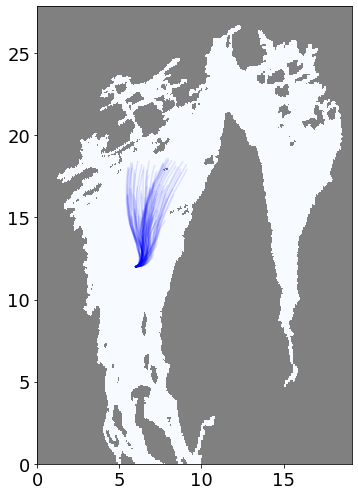

In [54]:
with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
    fig, ax = plt.subplots(1,1, figsize=(7,7))
    ax.tick_params(axis='both', which='major', labelsize=18)
    domain_extent = [0, sims.nx*sims.dx/1000, 0, sims.ny*sims.dy/1000]

    bg_cmap = copy.deepcopy(plt.cm.Blues)
    bg_cmap.set_bad("grey", alpha = 1.0)

    ax.imshow(barotropic_sims[0].download()[0] > -10, interpolation="none", origin='lower', 
                    cmap=bg_cmap,  
                    extent=domain_extent)

    for path in [t.get_drifter_path(0, 0, T, in_km = True)[0] for t in crossprod_trajectories]:
        ax.plot(path[:,0], path[:,1], color="blue", ls="-", zorder=5, alpha=0.1)

    plt.tight_layout()

    plt.savefig("figs/CPdrift.pdf")

### Purely barotropic 

In [55]:
pure_barotropic_sims = []

for i in range(2):
    barotropic_data_args["wind"] = winds[i]
    pure_barotropic_sims.append( CDKLM16.CDKLM16(bt_gpu_ctxs[i], **NetCDFInitialization.removeMetadata(barotropic_data_args),  dt=0.0))

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [56]:
observation_type = dautils.ObservationType.UnderlyingFlow 
    
observation_args = {'observation_type': observation_type,
                'nx': barotropic_sim.nx, 'ny': barotropic_sim.ny,
                'domain_size_x': barotropic_sim.nx*barotropic_sim.dx,
                'domain_size_y': barotropic_sim.ny*barotropic_sim.dy,
                'land_mask': barotropic_sim.getLandMask()
                }

trajectories = Observation.Observation(**observation_args)

In [57]:
initx = [ 6000]
inity = [12000]

num_drifters = len(initx)

In [58]:
import pandas as pd
bt_table = pd.DataFrame(columns=["drifter_id", "barotropic_id", "wind_drift_factor_id"]).set_index("drifter_id")

for bt in range(len(pure_barotropic_sims)):
    for wind in range(len(wind_drift_factors)):
        bt_table.loc[len(bt_table.index)] = [bt, wind]

In [59]:
bt_table

,barotropic_id,wind_drift_factor_id
drifter_id,,
0,0,0
1,0,1
2,0,2
3,1,0
4,1,1
5,1,2


In [60]:
crossbt_trajectories = []
for cp in range(len(bt_table)):
    crossbt_trajectories.append(copy.deepcopy(trajectories))

In [61]:
crossbt_drifters = []
for cp in range(len(bt_table)): 
    drifters = GPUDrifterCollection.GPUDrifterCollection(pure_barotropic_sims[bt_table.iloc[cp].barotropic_id].gpu_ctx, # OBS: This is used for wind drift! 
                                                    num_drifters,
                                                    boundaryConditions = barotropic_sim.boundary_conditions,
                                                    domain_size_x = trajectories.domain_size_x,
                                                    domain_size_y = trajectories.domain_size_y,
                                                    gpu_stream = barotropic_sim.gpu_stream,
                                                    wind=winds[bt_table.iloc[cp].barotropic_id], # using the barotropic wind
                                                    wind_drift_factor=wind_drift_factors[bt_table.iloc[cp].wind_drift_factor_id])          

    drifter_pos_init = np.array([initx, inity]).T
    drifters.setDrifterPositions(drifter_pos_init)
    crossbt_drifters.append(drifters)

In [62]:
from itertools import compress

for bt in range(len(pure_barotropic_sims)):
    pure_barotropic_sims[bt].attachCrossProductDrifters( list(compress(crossbt_drifters, bt_table["barotropic_id"] == bt)), int(np.sum(bt_table["barotropic_id"] == bt))* [None] )

In [63]:
while pure_barotropic_sims[0].t < T:
    for bt in pure_barotropic_sims:
        bt.step(60)

    for d in range(len(crossbt_drifters)):
        crossbt_trajectories[d].add_observation_from_drifters(crossbt_drifters[d], bt.t)

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  # This is added back by InteractiveShellApp.init_path()


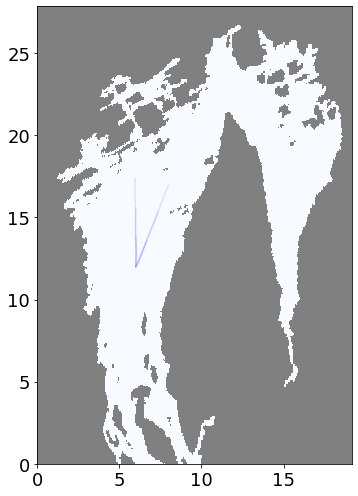

In [64]:
with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
    fig, ax = plt.subplots(1,1, figsize=(7,7))
    ax.tick_params(axis='both', which='major', labelsize=18)
    domain_extent = [0, sims.nx*sims.dx/1000, 0, sims.ny*sims.dy/1000]

    bg_cmap = copy.deepcopy(plt.cm.Blues)
    bg_cmap.set_bad("grey", alpha = 1.0)

    ax.imshow(pure_barotropic_sims[0].download()[0] > -10, interpolation="none", origin='lower', 
                    cmap=bg_cmap,  
                    extent=domain_extent)

    for path in [t.get_drifter_path(0, 0, T, in_km = True)[0] for t in crossbt_trajectories]:
        ax.plot(path[:,0], path[:,1], color="blue", ls="-", zorder=5, alpha=0.1)

    plt.tight_layout()

    plt.savefig("figs/CPdrift-bt.pdf")